In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4

In [2]:
y_test = np.load('/fast/gmooers/Preprocessed_Data/W_Half_Deep_Convection/Y_Test.npy')

In [6]:
print(y_test[:,0,0]==y_test[:,1,1])

[ True  True  True ...  True  True  True]


In [96]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Test.npy')

Max_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Max_Scalar.npy')
Min_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Min_Scalar.npy')

In [97]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy, mse
import tensorflow as tf
from keras.utils import plot_model

In [98]:
codings_size = 2

batch_size = 128
img_width = len(Training_Images[0])
img_height = len(Training_Images[0][0])
inputs = keras.layers.Input(shape=[img_width, img_height])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="relu")(z)
z = keras.layers.Dense(100, activation="relu")(z)
z = keras.layers.Dense(50, activation="relu")(z)
decoder_inputs = keras.layers.Dense(codings_size, activation="relu")(z)
x = keras.layers.Dense(50, activation="relu")(decoder_inputs)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dense(150, activation="relu")(x)
x = keras.layers.Dense(30*128, activation="sigmoid")(x)
outputs = keras.layers.Reshape([30,128])(x)

In [99]:
def reconstruction(true, pred):
    # Reconstruction loss
    #reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    reconstruction_loss = mse(K.flatten(true), K.flatten(pred)) * img_width * img_height
    return reconstruction_loss**4

In [100]:
lr = 7e-5
model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(Adam(lr), loss=loss, metrics=metrics)
opt = keras.optimizers.RMSprop(lr=lr)
model.compile(optimizer=opt, loss=reconstruction)

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 30, 128)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 150)               576150    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_35 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 102       
_________________________________________________________________
dense_37 (Dense)             (None, 50)                150       
__________

In [102]:
h = model.fit(Training_Images, Training_Images, epochs=30, batch_size=batch_size, validation_data=[Test_Images, Test_Images])

Train on 8371 samples, validate on 2093 samples
Epoch 1/30
8371/8371 [==============================] - 1s 155us/step - loss: 753351711.4127 - val_loss: 25782240.9345
Epoch 2/30
8371/8371 [==============================] - 1s 92us/step - loss: 5237386.5812 - val_loss: 225054.0516
Epoch 3/30
8371/8371 [==============================] - 1s 90us/step - loss: 54861.8054 - val_loss: 3405.2864
Epoch 4/30
8371/8371 [==============================] - 1s 92us/step - loss: 818.7403 - val_loss: 46.7765
Epoch 5/30
8371/8371 [==============================] - 1s 90us/step - loss: 11.3931 - val_loss: 0.7205
Epoch 6/30
8371/8371 [==============================] - 1s 91us/step - loss: 0.1869 - val_loss: 0.0152
Epoch 7/30
8371/8371 [==============================] - 1s 93us/step - loss: 0.0047 - val_loss: 8.5049e-04
Epoch 8/30
8371/8371 [==============================] - 1s 90us/step - loss: 0.0222 - val_loss: 0.0019
Epoch 9/30
8371/8371 [==============================] - 1s 96us/step - loss: 8.4593e-0

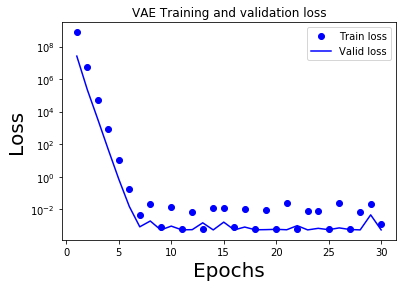

In [103]:
hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [104]:
Predict_Images = model.predict(Test_Images, batch_size=batch_size)
Unscaled_Predict_Images = np.interp(Predict_Images, (0, 1), (Min_Scalar, Max_Scalar))
Unscaled_Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.80616 #m/s^2
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
crm_spacing = (np.arange(0,128,1))
levs, lons = np.meshgrid(crm_spacing, P[:-1]/100.)

In [105]:
def min_max_gen(truths, predictions):
    my_list = [truths, predictions]
    max_list = []
    min_list = []
    for i in range(len(my_list)):
        values = my_list[i].ravel()
        max_list.append(np.max(values))
        min_list.append(np.min(values))
        
    vmax = np.max(np.array(max_list))
    vmin = np.min(np.array(min_list))

    return vmin, vmax

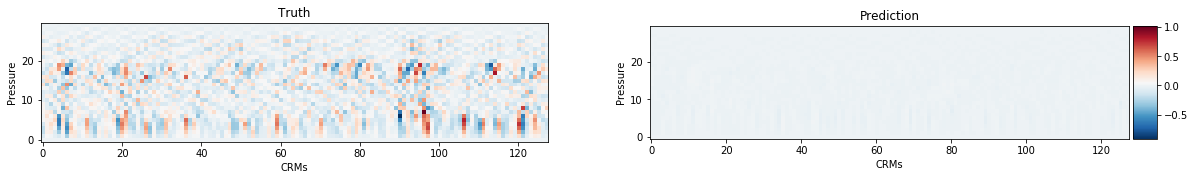

In [106]:
def comparison_gen(truth, pred, location):
    fig, axs = plt.subplots(1, 2, figsize=(20,26))
    cmap = 'RdBu_r'
    image_index = location
    datasets = [truth, pred]
    var_labels = ["Truth", "Prediction"]
    count = 0
    vmin, vmax = min_max_gen(truth[image_index,:,:], pred[image_index,:,:])
    for ax in axs.ravel():
        cs = ax.imshow(np.squeeze(datasets[count][image_index,:,:]), cmap=cmap, vmin = vmin, vmax = vmax)
        if count == 1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(cs, cax=cax)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel('CRMs')
        labels = [item.get_text() for item in ax.get_yticklabels()]
        labels = P  
        ax.set_ylabel('Pressure')
        ax.set_title(var_labels[count])
        count = count+1
        
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1915)

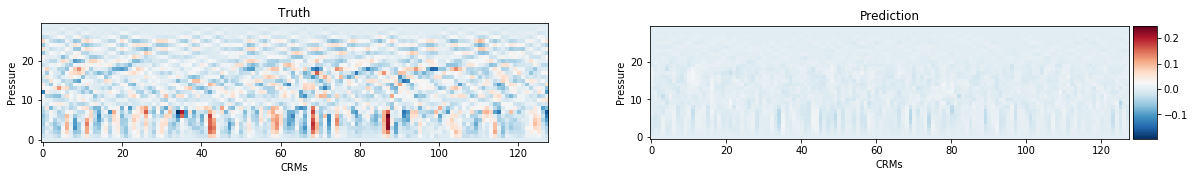

In [107]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1905)

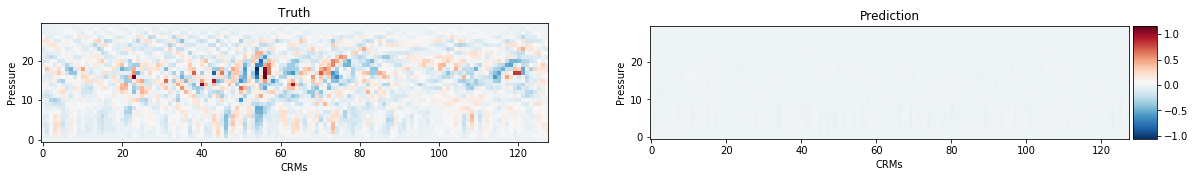

In [108]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1907)

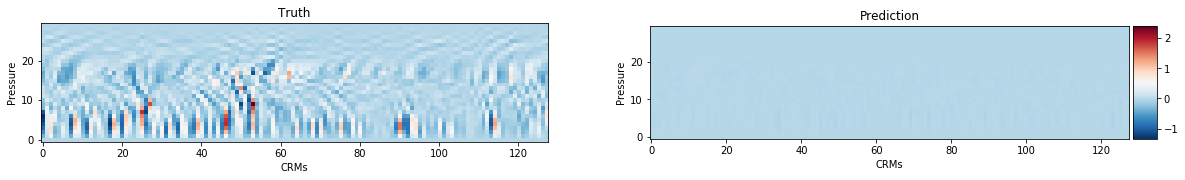

In [109]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1908)

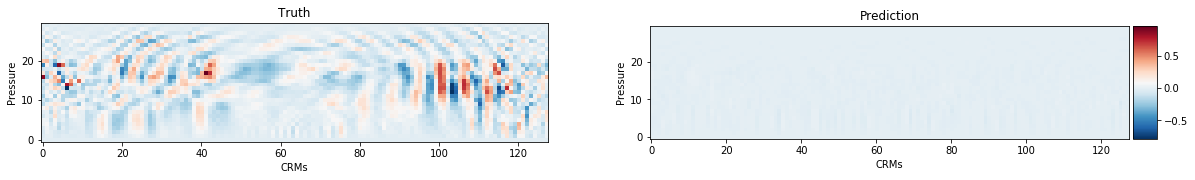

In [110]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1910)

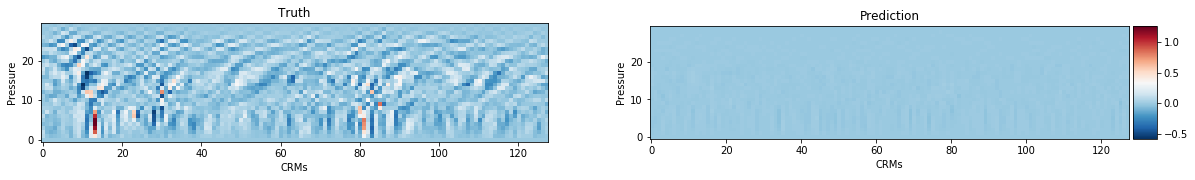

In [111]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1912)

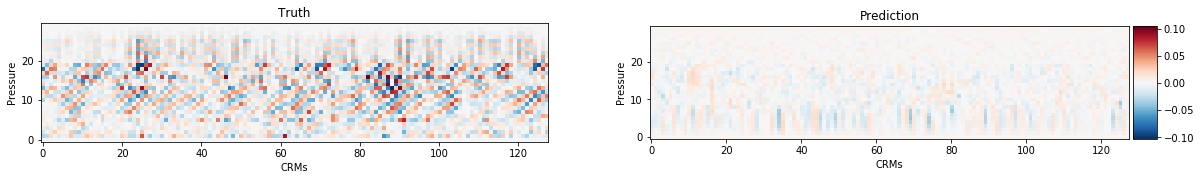

In [112]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1913)

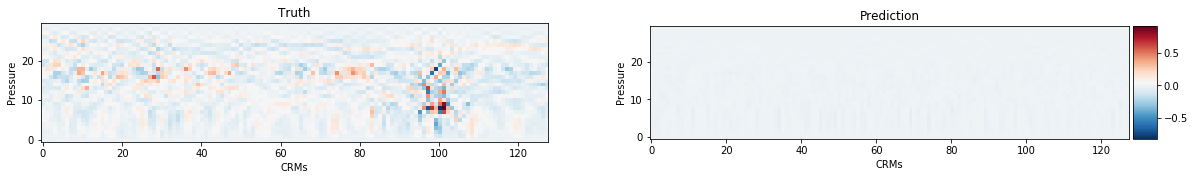

In [113]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1914)

In [114]:
del model
print(gdfhdshgh)

NameError: name 'gdfhdshgh' is not defined

In [ ]:
y_test = np.load('/fast/gmooers/VAE_Stuff/Y_Labels/Land_Sea.npy')
from sklearn.cluster import KMeans

In [ ]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_10_X/Space_Time_W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_10_X/Space_Time_W_Test.npy')

Unscaled_Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

In [ ]:
#N_cluster=4
#km = KMeans(n_clusters=N_cluster, init='k-means++')

In [ ]:
n
#y_km = km.fit_predict(Cluster_Test)

In [ ]:

group = {}
mean = {}
std = {}
for igroup in range(N_cluster):
    group[igroup] = Test_Images[y_km==igroup,:,:]
    mean[igroup] = np.mean(group[igroup],axis=0)
    std[igroup] = np.std(group[igroup],axis=0)

In [ ]:
for igroup in range(N_cluster):
    print(np.max(mean[igroup]))
    print(np.min(mean[igroup]))
    

In [ ]:
for igroup in range(N_cluster):
    print(np.max(std[igroup]))
    print(np.min(std[igroup]))

In [ ]:
for igroup in range(N_cluster):
    print(np.sum(y_km==igroup))

In [ ]:
vmax_mean = 0.37
vmin_mean = 0.20
vmax_std = 0.022325523204877725
vmin_std = 0.0
cmap="RdBu_r"
var_labels = ["Group 1", "Group 2", "Group 3", "Group 4"]
fig, ax = plt.subplots(nrows=N_cluster,ncols=2,figsize=(12.5,7.5))
for igroup in range(N_cluster):
    axes = ax[igroup]
    cs = axes[0].imshow(mean[igroup], cmap=cmap, vmax = vmax_mean, vmin = vmin_mean)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)
    cs = axes[1].imshow(std[igroup], cmap=cmap, vmax = vmax_std, vmin = vmin_std)
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)
    axes[0].set_ylim(axes[0].get_ylim()[::-1])
    axes[1].set_ylim(axes[1].get_ylim()[::-1])
    if igroup == 3:
        axes[0].set_xlabel('CRMs')
        axes[1].set_xlabel('CRMs')
    axes[0].set_ylabel('Pressure')
    #axes.set_title(var_labels[igroup])
    

In [ ]:
import numpy as np
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Test.npy')
Cluster_Test = Test_Images.reshape((len(Test_Images),128*30))

In [ ]:
var_preserved = 0.50
#var_preserved = 2
from sklearn.decomposition import PCA
pca = PCA(n_components=var_preserved)
pca.fit(Cluster_Test)
print('Variance for each component of the PCA is '+str(pca.explained_variance_ratio_))

In [ ]:
Reduced_dataset = pca.fit_transform(Cluster_Test)

In [ ]:
dir(pca)

In [ ]:
X = Cluster_Test
n_samples = X.shape[0]
# We center the data and compute the sample covariance matrix.
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
for eigenvector in pca.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

In [ ]:
import pandas as pd

https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

In [ ]:
SSE = []
for cluster in range(1,20):
    print(cluster)
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(Cluster_Test)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
del model